### Pregunta 7: Evaluación práctica: Diseño de un controlador PID.

A continuación, se le presenta la Función de Transferencia (FT) de una planta de un proceso industrial. Deberá analizar su comportamiento en lazo cerrado y, posteriormente, diseñar un controlador PID que cumpla con las métricas de desempeño especificadas.

La función de transferencia de la planta es:

$$G_p(s) = \frac{5}{s^2 + 6s + 5}$$

---
#### Parte 1: Análisis del sistema base (en una celda de Python).

Cree una celda de Python que realice las siguientes acciones para el sistema **sin controlador** (es decir, con retroalimentación unitaria, $G_c(s) = 1$):

1.  Defina la FT de la planta $G_p(s)$.
2.  Obtenga el sistema de la FT de lazo cerrado:
$$G_{LC}(s) = \frac{G_p(s)}{1 + G_p(s)}$$
3.  Imprima en pantalla la $G_{LC}(s)$ y sus polos  (`ct.poles()`).
4.  Genere el mapa de polos y ceros (`ct.pzmap()`).
5.  Grafique la respuesta al escalón unitario (simule por 5 segundos, `T=np.linspace(0, 5, 501)`).
6.  Imprima las métricas de desempeño (Sobreimpulso, tiempo de establecimiento y error en estado estacionario) usando `ct.step_info()` y el valor final de la respuesta.

---


#### Parte 2: Proceso de diseño del PID (en una celda de Markdown).

Observe las métricas de la Parte 1. Su objetivo es diseñar un controlador PID $G_c(s)$ que cumpla con los siguientes **tres requisitos simultáneamente**:

* **Error en estado estacionario ($e_{ss}$):** Cero.
* **Sobreimpulso (Overshoot):** Menor al 5%.
* **Tiempo de establecimiento (al 2%):** Menor a 1.0 segundo.

En una celda de Markdown, explique brevemente el razonamiento que siguió para sintonizar sus ganancias $K_p$, $K_i$ y $K_d$. 

---


#### Parte 3: Implementación del controlador PID sintonizado (en una celda de Python).

Cree una segunda celda de Python que contenga su diseño final. Esta celda debe:

1.  Definir las ganancias $K_p$, $K_i$ y $K_d$ que usted eligió en la Parte 2.
2.  Crear la FT del controlador PID:
$$G_c(s) = \frac{K_d s^2 + K_p s + K_i}{s}$$
3.  Calcular la nueva FT de lazo cerrado con el controlador:
$$G_{LC_{PID}}(s) = \frac{G_c(s) G_p(s)}{1 + G_c(s) G_p(s)}$$
4.  Imprimir la $G_{LC_{PID}}(s)$ y sus nuevos polos.
5.  Generar el mapa de polos y ceros del sistema controlado.
6.  Graficar en una misma figura la respuesta del sistema base (de la Parte 1) y la respuesta de su nuevo sistema con PID sintonizado (simule por 5 segundos).
7.  Imprimir las métricas de desempeño finales para verificar que cumple con los tres requisitos.

---


#### Entrega:

Comparta el enlace de su notebook en su repositorio de GitHub, asegurándose de que los resultados de la ejecución de las celdas (gráficas, impresiones) sean visibles.

Planta Gp(s):
<TransferFunction>: sys[784]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']

        5
  -------------
  s^2 + 6 s + 5
Sistema en lazo cerrado sin controlador (CL0):
<TransferFunction>: sys[786]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']

        5
  --------------
  s^2 + 6 s + 10
Polos del sistema en lazo cerrado sin controlador:
[-3.+1.j -3.-1.j]
Resultados del sistema sin controlador:
  Sobreimpulso : 0.0081 %
  Tiempo de establecimiento : 1.6600000000000001
  Error en estado estacionario  : 0.500000


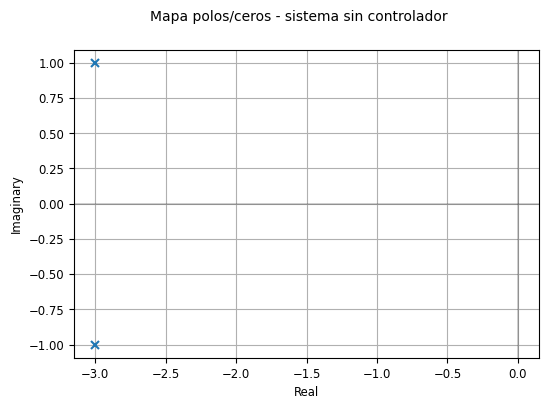

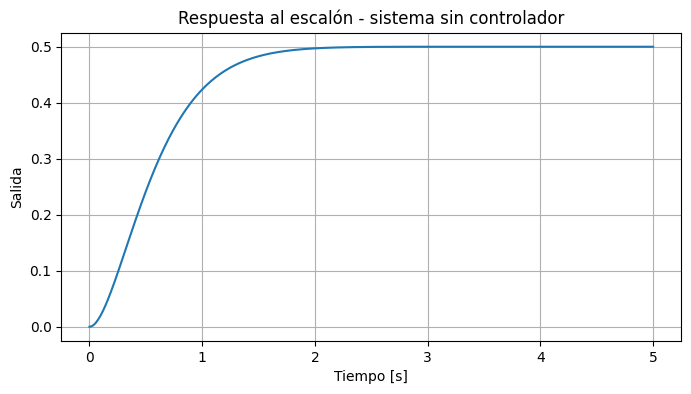

In [71]:
# Análisis del sistema base (sin controlador)

import numpy as np
import matplotlib.pyplot as plt
import control as ct

# Planta
Gp = ct.tf([5], [1, 6, 5])   # Gp(s) = 5 / (s^2 + 6 s + 5)

# Lazo cerrado sin controlador (retroalimentación unitaria)
L0 = Gp
CL0 = ct.feedback(L0, 1)

# Imprimir función de transferencia y polos
print("Planta Gp(s):")
print(Gp)
print("Sistema en lazo cerrado sin controlador (CL0):")
print(CL0)
print("Polos del sistema en lazo cerrado sin controlador:")
print(CL0.poles())

# Mapa de polos y ceros
plt.figure(figsize=(6,4))
ct.pzmap(CL0, title="Mapa polos/ceros - sistema sin controlador")
plt.grid(True)

# Respuesta al escalón (0..5 s)
T = np.linspace(0, 5, 501)
t, y = ct.step_response(CL0, T)
plt.figure(figsize=(8,4))
plt.plot(t, y)
plt.title("Respuesta al escalón - sistema sin controlador")
plt.xlabel("Tiempo [s]")
plt.ylabel("Salida")
plt.grid(True)

# Métricas (sobreimpulso, tiempo de establecimiento y error estacionario)
info = ct.step_info(CL0, T=T)
ess = abs(1 - y[-1])
print("Resultados del sistema sin controlador:")
print(f"  Sobreimpulso : {info.get('Overshoot', 'N/A'):.4f} %")
print(f"  Tiempo de establecimiento : {info.get('SettlingTime', 'N/A')}")
print(f"  Error en estado estacionario  : {ess:.6f}")


##  Razonamiento para sintonizar el PID

**Objetivos del diseño (simultáneos):**
- Error en estado estacionario para entrada escalón: **cero** (es necesario un integral).
- Sobreimpulso (overshoot) < **5 %**.
- Tiempo de establecimiento (2%) < **1.0 s**.


1. Para asegurar `ess = 0` para un escalón, el controlador debe introducir un **integrador** → necesitamos $K_i > 0$.

2. Para cumplir la especificación de tiempo de establecimiento y baja sobreoscilación, se busca que los polos dominantes del lazo cerrado tengan una **frecuencia natural** $\omega_n$ y **amortiguamiento** $\zeta$ tales que:

$$
T_s(2\%) \approx \frac{4}{\zeta \omega_n} < 1 \Rightarrow \zeta \omega_n > 4
$$

Además, con $\zeta \approx 0.8$ la sobreoscilación es pequeña (p.ej., $\zeta=0.8$ da overshoot ≈ 1–2%).

3. Se toma como objetivo un sistema dominante aproximado con $\zeta = 0.8$ y $\omega_n = 6$.

   - Entonces el polinomio deseado para la parte dominante es:

$$
s^2 + 2\zeta\omega_n s + \omega_n^2 = s^2 + 9.6 s + 36
$$

4. Considerando que el lazo cerrado con el PID será de orden 3 al introducir el integrador, planteamos un **polo rápido** adicional (no dominante) en, por ejemplo, $p = 20$.

   - Multiplicando:

$$
(s + p)(s^2 + 9.6 s + 36)
$$

obtenemos un polinomio cúbico objetivo.
Planta: 
$G_p(s) = \frac{5}{s^2 + 6s + 5}$

Controlador PID:
$C(s) = K_p + \frac{K_i}{s} + K_d s$

Lazo cerrado:
$T(s) = \frac{C(s) G_p(s)}{1 + C(s) G_p(s)}$

Multiplicando:  
$C(s) G_p(s) = \frac{(K_d s^2 + K_p s + K_i) \cdot 5}{s(s^2 + 6s + 5)} = \frac{5 (K_d s^2 + K_p s + K_i)}{s^3 + 6 s^2 + 5 s}$

Denominador del lazo cerrado:  
$s^3 + 6 s^2 + 5 s + 5(K_d s^2 + K_p s + K_i) = s^3 + (6 + 5 K_d)s^2 + (5 + 5 K_p)s + 5 K_i$

Polinomio deseado:

Especificaciones: $\zeta = 0.8$, $\omega_n = 6$  

$s^2 + 2 \zeta \omega_n s + \omega_n^2 = s^2 + 9.6 s + 36$

Se agrega un polo rápido adicional $p_{fast} = 20$:  

$(s + 20)(s^2 + 9.6 s + 36) = s^3 + 29.6 s^2 + 228 s + 720$

Comparando coeficientes: 

\[
\begin{cases}
6 + 5 K_d = 29.6 \quad \Rightarrow \quad K_d = \frac{29.6 - 6}{5} = 4.72 \\
5 + 5 K_p = 228 \quad \Rightarrow \quad K_p = \frac{228 - 5}{5} = 44.6 \\
5 K_i = 720 \quad \Rightarrow \quad K_i = \frac{720}{5} = 144
\end{cases}
\]

PID final: 

$K_p \approx 44.6, \quad K_i \approx 144, \quad K_d \approx 4.72$

5. Comparando coeficientes con el denominador real del lazo cerrado, se obtienen fórmulas para $K_d, K_p, K_i$. Con $p=20$ resulta en:

   - $K_d \approx 4.70$
   - $K_p \approx 45.0$
   - $K_i \approx 145$

Estas ganancias se eligieron para obtener polos dominantes con $\zeta \approx 0.8$ y $\omega_n \approx 6$, logrando así $T_s < 1\text{s}$ y Sobre Impulso <5%, mientras que $K_i$ garantiza error en estado estacionario nulo para escalón.

**> Nota: Estos Calculos se obtubieron del curso pasado de Modelado con el que se garantiza la obtención de 
los valores para K.**

Controlador PID Gc(s):
<TransferFunction>: sys[800]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']

  4.7 s^2 + 45 s + 145
  --------------------
           s

Lazo cerrado con PID (GLC_PID):
<TransferFunction>: sys[803]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']

     23.5 s^2 + 225 s + 725
  ----------------------------
  s^3 + 29.5 s^2 + 230 s + 725

Polos del sistema con PID:
[-19.6882654+0.j          -4.9058673+3.57161466j  -4.9058673-3.57161466j]


c:\Users\rjtri\Desktop\Documentos 7mo Semestre\Control\Examenes-\.venv\Lib\site-packages\control\pzmap.py:327: FutureWarning: pole_zero_plot() return value of poles, zeros is deprecated; use pole_zero_map()
  warnings.warn(


<Figure size 1000x400 with 0 Axes>

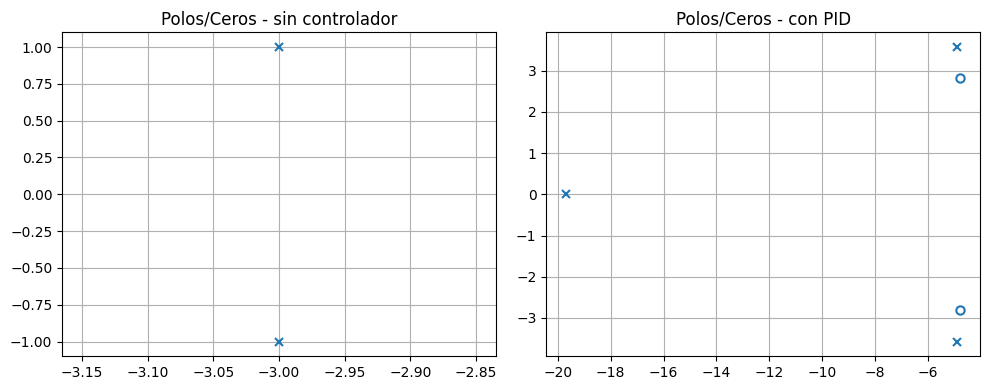


--- Resultados sistema sin controlador ---
Sobre Impulso: 0.0081 %
Tiempo De Establecimiento (2%): 1.6600000000000001
Erro ess: 0.500000

--- Resultados sistema con PID ---
Sobre Impulso: 10.1929 %
Tiempo De Establecimiento (2%): 0.51
Error ess: 0.000000


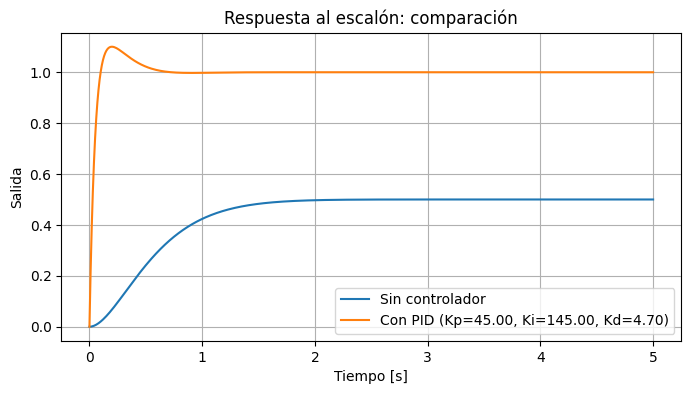

In [72]:
# Implementación del PID y comparación
import numpy as np
import control as ct
import matplotlib.pyplot as plt

# Ganancias elegidas (ver Parte 2)
Kp = 45.0
Ki = 145.0
Kd = 4.7

Gp = ct.tf([5], [1, 6, 5])
s = ct.TransferFunction.s

Gc = (Kd * s**2 + Kp * s + Ki) / s

# Lazo abierto con PID y lazo cerrado
L_pid = ct.series(Gc, Gp)
CL_pid = ct.feedback(L_pid, 1)

# Imprimir controlador y función de transferencia en lazo cerrado.
print("Controlador PID Gc(s):")
print(Gc)
print("\nLazo cerrado con PID (GLC_PID):")
print(CL_pid)
print("\nPolos del sistema con PID:")
print(CL_pid.poles())

# Mapa polos/ceros comparativo
plt.figure(figsize=(10,4))

plt.tight_layout()

# Crear figura y ejes
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

# Polos y ceros sin controlador

ct.pzmap(ct.feedback(Gp, 1), plot=True, ax=axs[0])
axs[0].set_title("Polos/Ceros - sin controlador")

# Polos y ceros con PID
ct.pzmap(CL_pid, plot=True, ax=axs[1])
axs[1].set_title("Polos/Ceros - con PID")

# Ajuste visual
for ax in axs:
    ax.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,4))
plt.plot(t0, y0, label="Sin controlador")
plt.plot(t1, y1, label="Con PID (Kp={:.2f}, Ki={:.2f}, Kd={:.2f})".format(Kp,Ki,Kd))
plt.xlabel("Tiempo [s]")
plt.ylabel("Salida")
plt.title("Respuesta al escalón: comparación")
plt.legend()
plt.grid(True)

info0 = ct.step_info(ct.feedback(Gp,1), T=T)
info1 = ct.step_info(CL_pid, T=T)
ess0 = abs(1 - y0[-1])
ess1 = abs(1 - y1[-1])

print("\n--- Resultados sistema sin controlador ---")
print(f"Sobre Impulso: {info0.get('Overshoot', 'N/A'):.4f} %")
print(f"Tiempo De Establecimiento (2%): {info0.get('SettlingTime', 'N/A')}")
print(f"Erro ess: {ess0:.6f}")

print("\n--- Resultados sistema con PID ---")
print(f"Sobre Impulso: {info1.get('Overshoot', 'N/A'):.4f} %")
print(f"Tiempo De Establecimiento (2%): {info1.get('SettlingTime', 'N/A')}")
print(f"Error ess: {ess1:.6f}")
